# Modelado
Conideraciones generales:

Se desarrolla un modelo de regresion con el objetivo de identificar la cantidad de productos vendidos de la publicacion. El algoritmo utilizado corresponde al lightgbm

La variable target se definio como la cantidad de productos vendidos(sold_quantity). Dentro del analisis exploratorio se identifico tiene uns distribucion sesgada positiva donde la el 50% de la misma corresponde al valor 0. Tambien se vio que no se encuentra relacionada con otras variables. 

Metodologia:
Se realizo la siguiente subdivisión del dataset en el momento de modelar:
* Train: Este dataset es utilizado para realizar el reentranamiento correspondiente. Debido al alto grado de desbalanceo del target se decidio calcular una muestra tomando en cuenta solo el 20% de la clase mayoritaria, este proceso se realizo solamente en esta muestra
* Test: Utilizado para definir el early stopping del algoritmo lightgbm
* Valid: Las metricas que se calcularan corresponden a este conjunto de datos. El mismo no se utilizo en ningun momento duarante el entrenamiento del modelo

Experimentacion:
Se realizaron las siguientes esperimenataciones:
* Modelar solamente con las variables cualitativas
* Aplicar tecnicas para eliminar los valores ouliers
* Incluir variables categoricas en el modelados
* Definir un esquema de ponderacion al calcular el error en el modelo 

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as ltb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *
import shap
import scipy.stats as stats
import seaborn as sns
shap.initjs()

In [2]:
# Cargo el dataset
df=pd.read_csv('dataset_clean.csv', index_col='id')
df.shape

(96182, 52)

In [3]:
X, y = (df.drop(['sold_quantity'], axis=1),
                df['sold_quantity'])

In [4]:
variablesCuantitativas = X.select_dtypes(include=['float64','int64']).columns
variablesCualitativas = X.select_dtypes(exclude=['float64','int64']).columns

In [5]:
# Separon en train, test y valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=314)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, random_state=314)

In [6]:
# Realizo el subsampleo solamente en el target
X_train['target'] = y_train
X_train =pd.concat([
                    X_train[(X_train.target==0) | (X_train.target>250)].sample(frac=0.25), 
                    X_train[~((X_train.target==0) | (X_train.target>250))]
                    ]
                ).sample(frac=1)
X_train, y_train = (X_train.drop(['target'], axis=1), X_train['target'])

In [7]:
# Configuracion utilizada en el entrenamiento
parameters = {'num_leaves': stats.randint(6, 50), 
             'min_child_samples': stats.randint(100, 500),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': stats.uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': stats.uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

cantidad_iteracion_params = 100
cv=3
resultadosModelos = []
resuldatosCrudos = {'Real':y_valid}

## Primer modelos solo variables cuantitativas

In [8]:
model = ltb.LGBMRegressor(n_estimators=10000,verbose=0) 
clf = RandomizedSearchCV(model,random_state=10, cv=cv, param_distributions=parameters,
                                   n_iter=cantidad_iteracion_params,
                         verbose=True,n_jobs=-1,scoring='neg_mean_absolute_error')  

clf.fit(
    X=X_train[variablesCuantitativas], 
        y=y_train, 
        early_stopping_rounds=10,
        eval_metric='neg_mean_absolute_error',
        eval_set=(X_test[variablesCuantitativas],y_test)
       )
print('Best Score: %s' % clf.best_score_)
print('Best Hyperparameters: %s' % clf.best_params_)
print('Mean Score: %s' % np.mean(clf.cv_results_['mean_test_score']))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.5min finished


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l2: 123185
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 121494
[3]	valid_0's l2: 119993
[4]	valid_0's l2: 118810
[5]	valid_0's l2: 117760
[6]	valid_0's l2: 116887
[7]	valid_0's l2: 115957
[8]	valid_0's l2: 115264
[9]	valid_0's l2: 114696
[10]	valid_0's l2: 114241
[11]	valid_0's l2: 113795
[12]	valid_0's l2: 113366
[13]	valid_0's l2: 113030
[14]	valid_0's l2: 112648
[15]	valid_0's l2: 112386
[16]	valid_0's l2: 112176
[17]	valid_0's l2: 111886
[18]	valid_0's l2: 111669
[19]	valid_0's l2: 111396
[20]	valid_0's l2: 111298
[21]	valid_0's l2: 111216
[22]	valid_0'

Revision del modelo

In [9]:
y_pred = clf.predict(X_valid[variablesCuantitativas]) ## Poner la mejor iteracion
residuo = y_valid - y_pred
print("explained_variance_score:",explained_variance_score(y_valid, y_pred))
print("mean_absolute_error:",mean_absolute_error(y_valid, y_pred))
print("mean_squared_error:",mean_squared_error(y_valid, y_pred))
print("r2_score:",r2_score(y_valid, y_pred))


resuldatosCrudos['Variables cuantitativas'] = y_pred
resultadosModelos.append({
    "Nombre": "Primer modelo - Solo variables cuantitativas",
    "explained_variance_score": explained_variance_score(y_valid, y_pred),
    "mean_absolute_error": mean_absolute_error(y_valid, y_pred),
    "mean_squared_error": mean_squared_error(y_valid, y_pred),
    "r2_score": r2_score(y_valid, y_pred),
})

explained_variance_score: 0.5717467774261159
mean_absolute_error: 15.88457659295991
mean_squared_error: 18787.09971422384
r2_score: 0.5714671611741116


In [10]:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_valid[variablesCuantitativas])
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid[variablesCuantitativas].iloc[0,:])

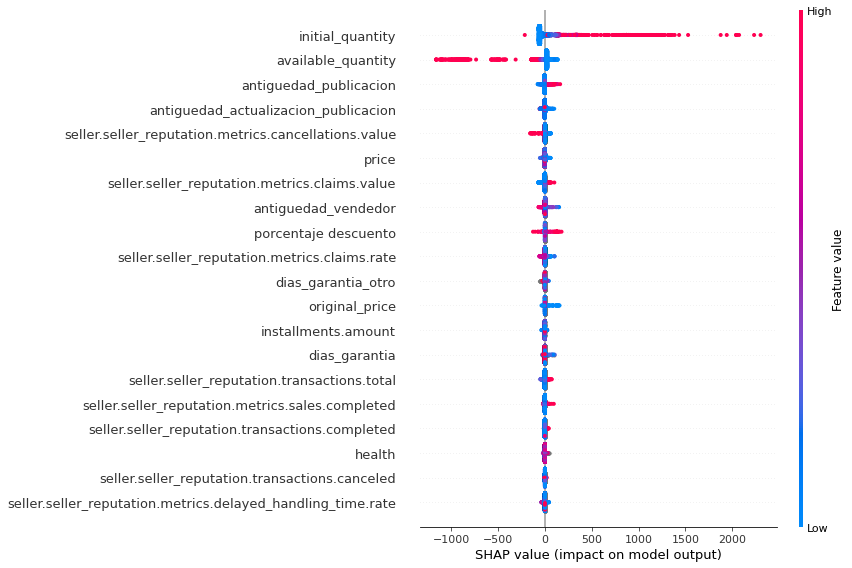

In [11]:
shap.summary_plot(shap_values, X_valid[variablesCuantitativas])

**Tal cual se esperaba la gran mayoria de las variables tienen una importancia baja**

Text(0.5, 1.0, 'Normal Q-Q Plot')

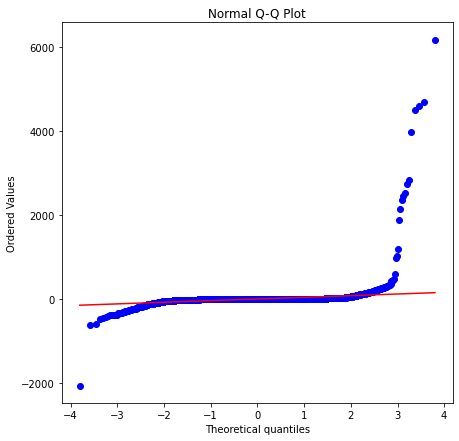

In [12]:
plt.figure(figsize=(7,7))
stats.probplot(residuo, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

**El residuo tiene una distribucion normal aproximanda, en los extramos es donde se encuenta la mayor diferencia.**

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0.5, 1.0, 'Valor predicho')

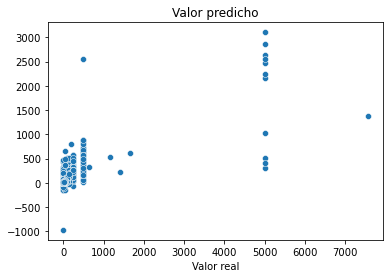

In [13]:
# Valid y pred
sns.scatterplot(y_valid,y_pred)
plt.xlabel("Valor real")
plt.title('Valor predicho')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Residuo')

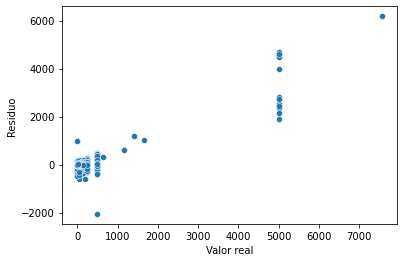

In [14]:
# Valid y pred
sns.scatterplot(y_valid,residuo)
plt.xlabel("Valor real")
plt.ylabel('Residuo')

In [15]:
result = pd.DataFrame({'Real': y_valid,'Predicho': y_pred})
result['Residuo'] = np.abs(result['Real'] - result['Predicho'])
result['Real_bins'] = pd.qcut(result['Real'],20,duplicates='drop')
dist_results = result.groupby('Real_bins')['Residuo'].agg(['mean'])

dist_results

,mean
Real_bins,
"(-0.001, 1.0]",1.950269
"(1.0, 3.0]",6.719167
"(3.0, 5.0]",9.022390
"(5.0, 25.0]",17.009187
"(25.0, 50.0]",23.542258
"(50.0, 100.0]",28.299110
"(100.0, 250.0]",35.184889
"(250.0, 7559.0]",252.426739


# Elimino los ouliers

In [16]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outliers = clf.fit_predict(X_train[variablesCuantitativas].fillna(-1))
mask = outliers != -1
X_sin_ouliers, y_train_sin_ouliers = X_train[mask], y_train[mask]


y_train_sin_ouliers = y_train_sin_ouliers.clip(upper=y_train_sin_ouliers.quantile(.98)) # Agrego 

model = ltb.LGBMRegressor(n_estimators=1000,verbose=0) 
clf = RandomizedSearchCV(model,random_state=10, cv=cv,param_distributions=parameters,
                                   n_iter=cantidad_iteracion_params,
                         verbose=True,n_jobs=-1,scoring='neg_mean_absolute_error')  

clf.fit(
    X=X_sin_ouliers[variablesCuantitativas], 
        y=y_train_sin_ouliers, 
        early_stopping_rounds=10,
        eval_metric='neg_mean_absolute_error',
        eval_set=(X_test[variablesCuantitativas], y_test)
       )

print('Best Score: %s' % clf.best_score_)
print('Best Hyperparameters: %s' % clf.best_params_)
print('Mean Score: %s' % np.mean(clf.cv_results_['mean_test_score']))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.7min finished


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l2: 124165
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 123221
[3]	valid_0's l2: 122458
[4]	valid_0's l2: 121790
[5]	valid_0's l2: 121184
[6]	valid_0's l2: 120671
[7]	valid_0's l2: 120237
[8]	valid_0's l2: 119832
[9]	valid_0's l2: 119477
[10]	valid_0's l2: 119169
[11]	valid_0's l2: 118910
[12]	valid_0's l2: 118658
[13]	valid_0's l2: 118452
[14]	valid_0's l2: 118251
[15]	valid_0's l2: 118072
[16]	valid_0's l2: 117917
[17]	valid_0's l2: 117777
[18]	valid_0's l2: 117665
[19]	valid_0's l2: 117549
[20]	valid_0's l2: 117454
[21]	valid_0's l2: 117367
[22]	valid_0'

In [17]:
y_pred = clf.predict(X_valid[variablesCuantitativas]) ## Poner la mejor iteracion
residuo = y_valid - y_pred

print("explained_variance_score:",explained_variance_score(y_valid, y_pred))
print("mean_absolute_error:",mean_absolute_error(y_valid, y_pred))
print("mean_squared_error:",mean_squared_error(y_valid, y_pred))
print("r2_score:",r2_score(y_valid, y_pred))

resultadosModelos.append({
    "Nombre": "Sin Ourliers",
    "explained_variance_score": explained_variance_score(y_valid, y_pred),
    "mean_absolute_error": mean_absolute_error(y_valid, y_pred),
    "mean_squared_error": mean_squared_error(y_valid, y_pred),
    "r2_score": r2_score(y_valid, y_pred),
})

resuldatosCrudos['Sin Ourliers'] = y_pred

explained_variance_score: 0.21945347818743344
mean_absolute_error: 19.79909203324077
mean_squared_error: 34408.01593984611
r2_score: 0.21515481509340384


In [18]:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_valid[variablesCuantitativas])
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid[variablesCuantitativas].iloc[0,:])

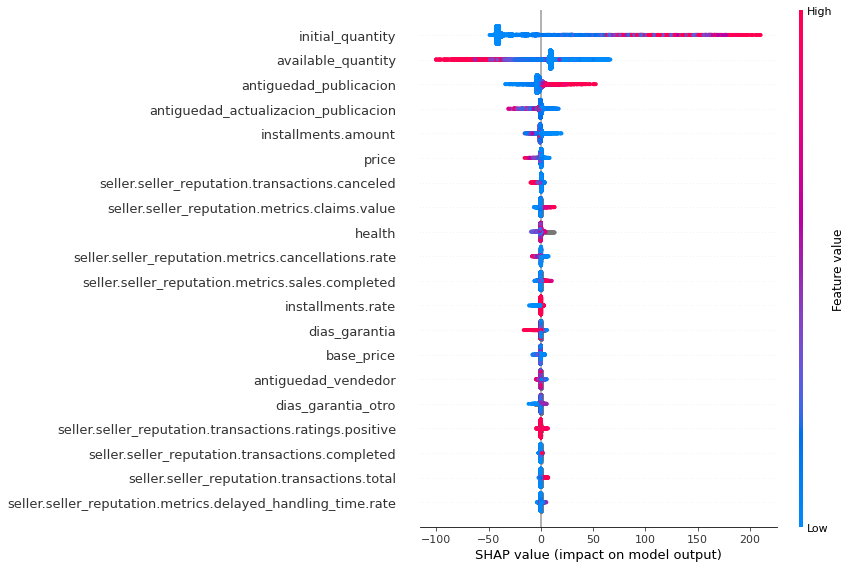

In [19]:
shap.summary_plot(shap_values, X_valid[variablesCuantitativas])

Text(0.5, 1.0, 'Normal Q-Q Plot')

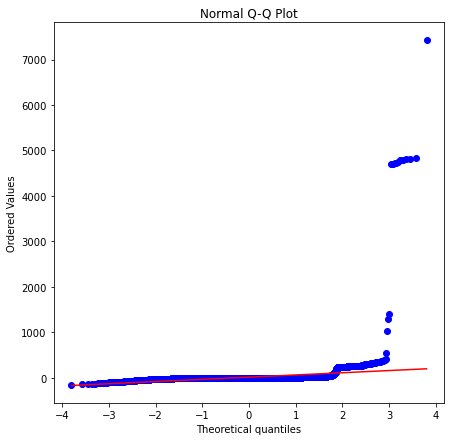

In [20]:
plt.figure(figsize=(7,7))
stats.probplot(residuo, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Valor predicho')

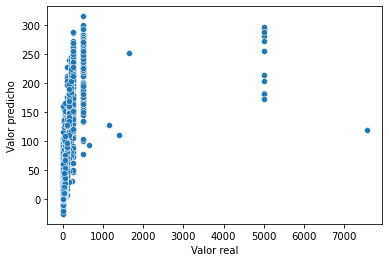

In [21]:
# Valid y pred
sns.scatterplot(y_valid,y_pred)
plt.xlabel("Valor real")
plt.ylabel('Valor predicho')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Residuo')

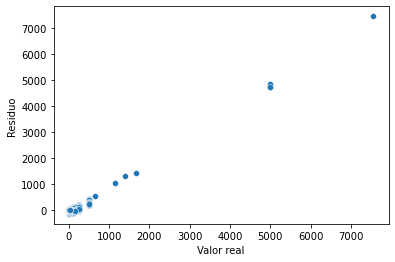

In [22]:
# Valid y pred
sns.scatterplot(y_valid,residuo)
plt.xlabel("Valor real")
plt.ylabel('Residuo')

In [23]:
result = pd.DataFrame({'Real': y_valid,'Predicho': y_pred})
result['Residuo'] = np.abs(result['Real'] - result['Predicho'])
result['Real_bins'] = pd.qcut(result['Real'],40,duplicates='drop')
result.groupby('Real_bins')['Residuo'].agg(['mean','count'])

,mean,count
Real_bins,,
"(-0.001, 1.0]",1.075399,5434
"(1.0, 2.0]",2.722134,235
"(2.0, 3.0]",4.467486,174
"(3.0, 5.0]",6.270513,1433
"(5.0, 25.0]",13.197673,625
"(25.0, 50.0]",16.206089,569
"(50.0, 100.0]",22.303317,262
"(100.0, 150.0]",21.864889,197
"(150.0, 250.0]",26.260887,396


# Agrego las variabels categoricas

In [24]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outliers = clf.fit_predict(X_train[variablesCuantitativas].fillna(-1))
mask = outliers != -1
X_sin_ouliers, y_train_sin_ouliers = X_train[mask], y_train[mask]

y_train_sin_ouliers = y_train_sin_ouliers.clip(upper=y_train_sin_ouliers.quantile(.98)) # Agrego 
    
for variableCualitativas in variablesCualitativas:
    X_sin_ouliers[variableCualitativas] = pd.Series(X_train[variableCualitativas], dtype="category")
    X_test[variableCualitativas] = pd.Series(X_test[variableCualitativas], dtype="category")
    X_valid[variableCualitativas] = pd.Series(X_valid[variableCualitativas], dtype="category")

model = ltb.LGBMRegressor(n_estimators=1000,verbose=0) 
clf = RandomizedSearchCV(model,random_state=10, cv=cv,param_distributions=parameters,
                                   n_iter=cantidad_iteracion_params,
                         verbose=True,n_jobs=-1,scoring='neg_mean_absolute_error')  

clf.fit(
    X=X_sin_ouliers, 
        y=y_train_sin_ouliers, 
        early_stopping_rounds=5,
        #eval_metric='neg_mean_absolute_error',
        eval_set=(X_test,y_test)
       )

print('Best Score: %s' % clf.best_score_)
print('Best Hyperparameters: %s' % clf.best_params_)
print('Mean Score: %s' % np.mean(clf.cv_results_['mean_test_score']))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.3min finished


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l2: 124121
Training until validation scores don't improve for 5 rounds


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[2]	valid_0's l2: 123173
[3]	valid_0's l2: 122359
[4]	valid_0's l2: 121670
[5]	valid_0's l2: 121051
[6]	valid_0's l2: 120512
[7]	valid_0's l2: 120071
[8]	valid_0's l2: 119673
[9]	valid_0's l2: 119327
[10]	valid_0's l2: 119009
[11]	valid_0's l2: 118741
[12]	valid_0's l2: 118502
[13]	valid_0's l2: 118291
[14]	valid_0's l2: 118089
[15]	valid_0's l2: 117919
[16]	valid_0's l2: 117835
[17]	valid_0's l2: 117691
[18]	valid_0's l2: 117577
[19]	valid_0's l2: 117452
[20]	valid_0's l2: 117340
[21]	valid_0's l2: 117279
[22]	valid_0's l2: 117181
[23]	valid_0's l2: 117096
[24]	valid_0's l2: 117010
[25]	valid_0's l2: 116940
[26]	valid_0's l2: 116879
[27]	valid_0's l2: 116838
[28]	valid_0's l2: 116800
[29]	valid_0's l2: 116755
[30]	valid_0's l2: 116720
[31]	valid_0's l2: 116685
[32]	valid_0's l2: 116642
[33]	valid_0's l2: 116607
[34]	valid_0's l2: 116569
[35]	valid_0's l2: 116538
[36]	valid_0's l2: 116501
[37]	valid_0's l2: 116469
[38]	valid_0's l2: 116443
[39]	valid_0's l2: 116427
[40]	valid_0's l2: 1

In [25]:
y_pred = clf.predict(X_valid) ## Poner la mejor iteracion

residuo = y_valid - y_pred

print("explained_variance_score:",explained_variance_score(y_valid, y_pred))
print("mean_absolute_error:",mean_absolute_error(y_valid, y_pred))
print("mean_squared_error:",mean_squared_error(y_valid, y_pred))
print("r2_score:",r2_score(y_valid, y_pred))


resultadosModelos.append({
    "Nombre": "Con categoricas",
    "explained_variance_score": explained_variance_score(y_valid, y_pred),
    "mean_absolute_error": mean_absolute_error(y_valid, y_pred),
    "mean_squared_error": mean_squared_error(y_valid, y_pred),
    "r2_score": r2_score(y_valid, y_pred),
})

resuldatosCrudos['Con categoricas'] = y_pred

explained_variance_score: 0.21968176216875734
mean_absolute_error: 20.04581062032146
mean_squared_error: 34396.68649899698
r2_score: 0.21541323909302246


In [26]:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_valid)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid.iloc[0,:])

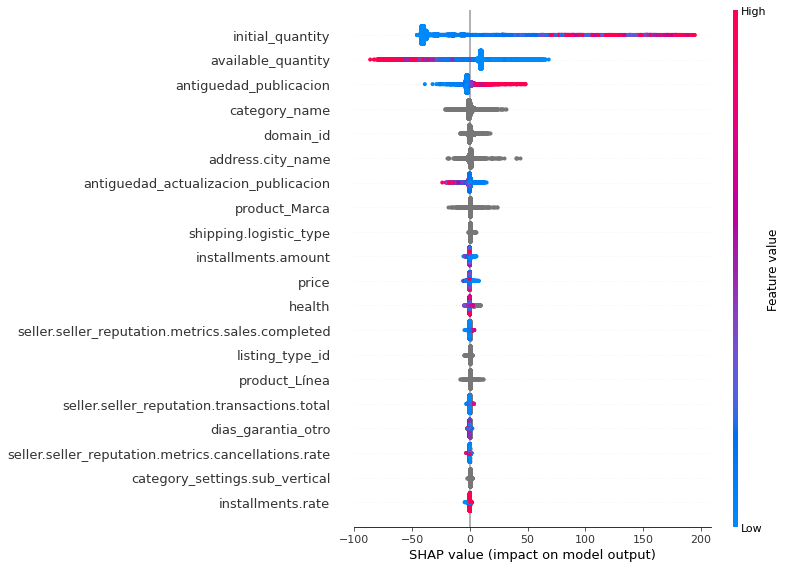

In [27]:
shap.summary_plot(shap_values, X_valid)

Text(0.5, 1.0, 'Normal Q-Q Plot')

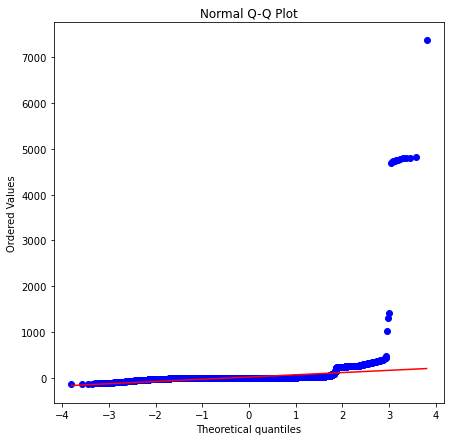

In [28]:
plt.figure(figsize=(7,7))
stats.probplot(residuo, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Valor predicho')

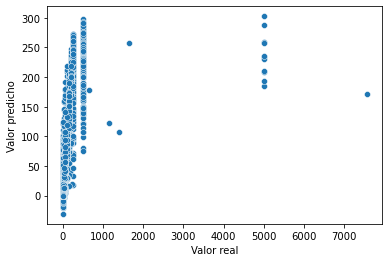

In [29]:
# Valid y pred
sns.scatterplot(y_valid,y_pred)
plt.xlabel("Valor real")
plt.ylabel('Valor predicho')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Residuo')

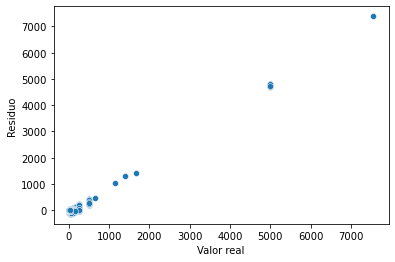

In [30]:
# Valid y pred
sns.scatterplot(y_valid,residuo)
plt.xlabel("Valor real")
plt.ylabel('Residuo')

In [31]:
result = pd.DataFrame({'Real': y_valid,'Predicho': y_pred})
result['Residuo'] = np.abs(result['Real'] - result['Predicho'])
result['Real_bins'] = pd.qcut(result['Real'],40,duplicates='drop')
result.groupby('Real_bins')['Residuo'].agg(['mean'])

,mean
Real_bins,
"(-0.001, 1.0]",1.207863
"(1.0, 2.0]",2.759697
"(2.0, 3.0]",4.766243
"(3.0, 5.0]",6.289449
"(5.0, 25.0]",13.036384
"(25.0, 50.0]",17.329593
"(50.0, 100.0]",21.822502
"(100.0, 150.0]",23.063846
"(150.0, 250.0]",28.314685


# Agrego Weights

In [32]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outliers = clf.fit_predict(X_train[variablesCuantitativas].fillna(-1))
mask = outliers != -1
X_sin_ouliers, y_train_sin_ouliers = X_train[mask], y_train[mask]
    
y_train_sin_ouliers = y_train_sin_ouliers.clip(upper=y_train_sin_ouliers.quantile(.95)) # Agrego 
    
for variableCualitativas in variablesCualitativas:
    X_sin_ouliers[variableCualitativas] = pd.Series(X_train[variableCualitativas], dtype="category")
    X_test[variableCualitativas] = pd.Series(X_test[variableCualitativas], dtype="category")
    X_valid[variableCualitativas] = pd.Series(X_valid[variableCualitativas], dtype="category")

model = ltb.LGBMRegressor(n_estimators=1000,verbose=0) 
clf = RandomizedSearchCV(model,
                         random_state=10, 
                        cv=cv,
                         param_distributions=parameters,
                         n_iter=cantidad_iteracion_params,
                         verbose=True,n_jobs=-1,scoring='neg_mean_absolute_error')  

clf.fit(
    X=X_sin_ouliers, 
        y=y_train_sin_ouliers, 
        sample_weight=y_train_sin_ouliers.map(lambda x: 1 if x==0 else 5),
        early_stopping_rounds=10,
        eval_metric=['mae','neg_mean_absolute_error'],
        eval_set=(X_test,y_test)
       )

print('Best Score: %s' % clf.best_score_)
print('Best Hyperparameters: %s' % clf.best_params_)
print('Mean Score: %s' % np.mean(clf.cv_results_['mean_test_score']))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.9min finished


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's l1: 60.2917	valid_0's l2: 124099
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 56.2339	valid_0's l2: 123142
[3]	valid_0's l1: 52.6586	valid_0's l2: 122354
[4]	valid_0's l1: 49.4003	valid_0's l2: 121661
[5]	valid_0's l1: 46.5139	valid_0's l2: 121082
[6]	valid_0's l1: 43.8588	valid_0's l2: 120553
[7]	valid_0's l1: 41.4989	valid_0's l2: 120118
[8]	valid_0's l1: 39.3273	valid_0's l2: 119718
[9]	valid_0's l1: 37.4181	valid_0's l2: 119357
[10]	valid_0's l1: 35.7328	valid_0's l2: 119070
[11]	valid_0's l1: 34.2063	valid_0's l2: 118823
[12]	valid_0's l1: 32.8198	valid_0's l2: 118570
[13]	valid_0's l1: 31.5925	valid_0's l2: 118361
[14]	valid_0's l1: 30.4627	valid_0's l2: 118170
[15]	valid_0's l1: 29.4814	valid_0's l2: 117995
[16]	valid_0's l1: 28.6039	valid_0's l2: 117853
[17]	valid_0's l1: 27.7274	valid_0's l2: 117695
[18]	valid_0's l1: 26.9892	valid_0's l2: 117571
[19]

In [33]:
y_pred = clf.predict(X_valid) ## Poner la mejor iteracion

residuo = y_valid - y_pred


print("explained_variance_score:",explained_variance_score(y_valid, y_pred))
print("mean_absolute_error:",mean_absolute_error(y_valid, y_pred))
print("mean_squared_error:",mean_squared_error(y_valid, y_pred))
print("r2_score:",r2_score(y_valid, y_pred))

resultadosModelos.append({
    "Nombre": "Con weights",
    "explained_variance_score": explained_variance_score(y_valid, y_pred),
    "mean_absolute_error": mean_absolute_error(y_valid, y_pred),
    "mean_squared_error": mean_squared_error(y_valid, y_pred),
    "r2_score": r2_score(y_valid, y_pred),
})
resuldatosCrudos['Con weights'] = y_pred

explained_variance_score: 0.21955959369340383
mean_absolute_error: 20.233919210912394
mean_squared_error: 34393.85936209704
r2_score: 0.2154777259494246


In [34]:
explainer = shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer.shap_values(X_valid)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_valid.iloc[0,:])

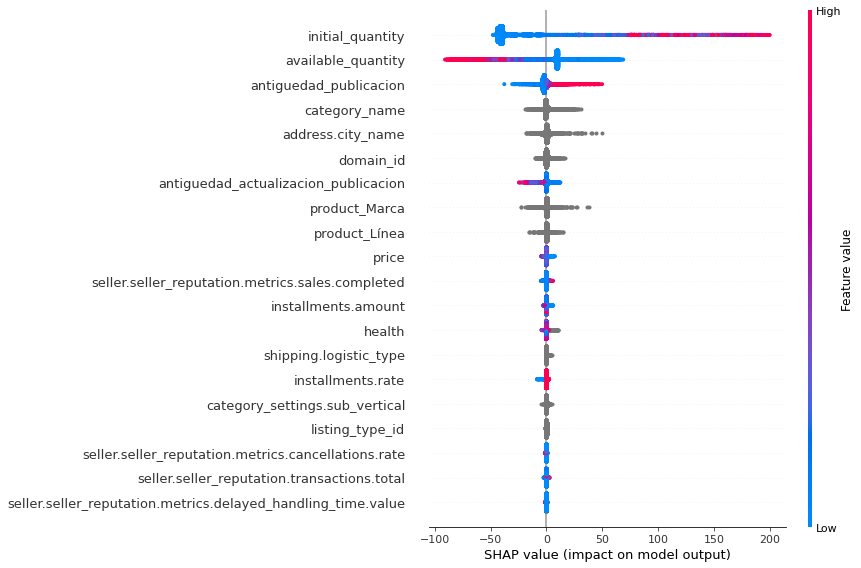

In [35]:
shap.summary_plot(shap_values, X_valid)

Text(0.5, 1.0, 'Normal Q-Q Plot')

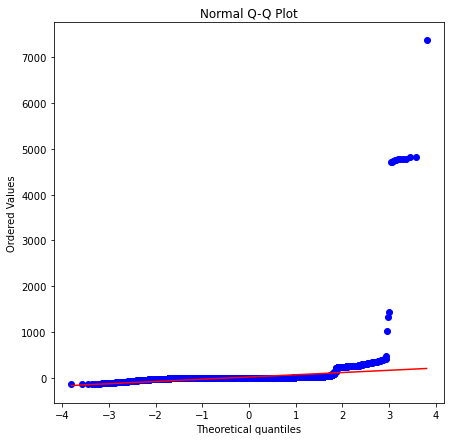

In [36]:
plt.figure(figsize=(7,7))
stats.probplot(residuo, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Valor predicho')

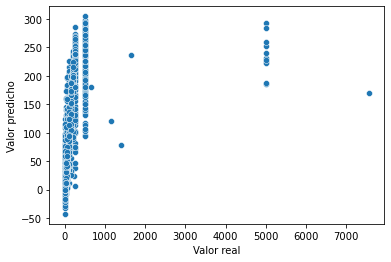

In [37]:
# Valid y pred
sns.scatterplot(y_valid,y_pred)
plt.xlabel("Valor real")
plt.ylabel('Valor predicho')

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


Text(0, 0.5, 'Residuo')

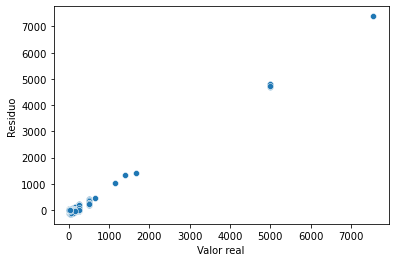

In [38]:
# Valid y pred
sns.scatterplot(y_valid,residuo)
plt.xlabel("Valor real")
plt.ylabel('Residuo')

In [39]:
result = pd.DataFrame({'Real': y_valid,'Predicho': y_pred})
result['Residuo'] = np.abs(result['Real'] - result['Predicho'])
result['Real_bins'] = pd.qcut(result['Real'],40,duplicates='drop')
result.groupby('Real_bins')['Residuo'].agg(['mean'])

,mean
Real_bins,
"(-0.001, 1.0]",1.567454
"(1.0, 2.0]",2.622375
"(2.0, 3.0]",4.825384
"(3.0, 5.0]",6.190869
"(5.0, 25.0]",13.029133
"(25.0, 50.0]",17.470564
"(50.0, 100.0]",22.657366
"(100.0, 150.0]",23.145687
"(150.0, 250.0]",28.518575


# Resultados finales

In [40]:
pd.DataFrame(resultadosModelos)

,Nombre,explained_variance_score,mean_absolute_error,mean_squared_error,r2_score
0,Primer modelo - Solo variables cuantitativas,0.571747,15.884577,18787.099714,0.571467
1,Sin Ourliers,0.219453,19.799092,34408.015940,0.215155
2,Con categoricas,0.219682,20.045811,34396.686499,0.215413
3,Con weights,0.219560,20.233919,34393.859362,0.215478


In [41]:
aux = pd.DataFrame(resuldatosCrudos)
aux['Variables cuantitativas_residuo'] = np.abs(aux['Real'] - aux['Variables cuantitativas'])
aux['Sin Ourliers_residuo'] = np.abs(aux['Real'] - aux['Sin Ourliers'])
aux['Con categoricas_residuo'] = np.abs(aux['Real'] - aux['Con categoricas'])
aux['Con weights_residuo'] = np.abs(aux['Real'] - aux['Con weights'])

aux['Real_bins'] = pd.qcut(aux['Real'],20,duplicates='drop')
aux.groupby('Real_bins')['Variables cuantitativas_residuo','Sin Ourliers_residuo','Con categoricas_residuo',
                         'Con weights_residuo'
                        ].agg(['mean','count'])

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


Variables cuantitativas_residuo       Sin Ourliers_residuo  \
                                           mean count                 mean   
Real_bins                                                                    
(-0.001, 1.0]                          1.950269  5434             1.075399   
(1.0, 3.0]                             6.719167   409             3.464655   
(3.0, 5.0]                             9.022390  1433             6.270513   
(5.0, 25.0]                           17.009187   625            13.197673   
(25.0, 50.0]                          23.542258   569            16.206089   
(50.0, 100.0]                         28.299110   262            22.303317   
(100.0, 250.0]                        35.184889   593            24.800496   
(250.0, 7559.0]                      252.426739   294           463.200974   

                      Con categoricas_residuo       Con weights_residuo        
                count                    mean count                mean count  
Real_bins                                                                      
(-0.001, 1.0]    5434                1.207863  5434            1.567454  5434  
(1.0, 3.0]        409                3.613337   409            3.559596   409  
(3.0, 5.0]       1433                6.289449  1433            6.190869  1433  
(5.0, 25.0]       625               13.036384   625           13.029133   625  
(25.0, 50.0]      569               17.329593   569           17.470564   569  
(50.0, 100.0]     262               21.822502   262           22.657366   262  
(100.0, 250.0]    593               26.570309   593           26.733653   593  
(250.0, 7559.0]   294              463.552791   294          462.285336   294

El mejor modelo surgio utilizando solamente las variables cuantitativas, donde se ve que tiene un error promedio de 13,44 ventas con un r2 de %%%. Las distribucion del error del error por decil se ve correcta, pero exista un error importante en el ultimo decil(Ventas > a 250).

El grafico de residuos demuestra que existen valores atipicos que afectan a la regresion, este punto se propone como punto a revisar

Puntos a revisar:
* Se ve necesario contar mayor informacion y tambien enrriquerese eldataset con otras fuentes de datos.
* Realizar otras experimentaciones sobre los ouliers como estandarizar al percentil 1 y 99, aplicar funcion logaritmica, eliminarlo mediante tecnicas no supervisadas, Isolation Forest, Robust Random Cut Forest
* Las variables categoricas tienen una alta cardinalidad. Aplicar tecnicas para deducirlas
* Aplicar otros tipos de transformaciones en variabels categoricas, como por ejemplo crear variables
* Tecnicas de balanceo de muestras en regresiones
* Redefinicion del target, por ejemplo armar un modelo de clasificacion con los bins